### Ising Model


The lattice I used is a 50 by 50 grid. The idea behind the algorithm is to pick a random point on the grid, look at the probability ratio to change:
$$
P =\frac{P_{f}}{P_{i}} = \frac{exp(-\frac{E_{f}}{k_{B}T})}{exp(-\frac{E_{i}}{k_{B}T})} = exp(-\frac{E_{f} - E_{i}}{k_{B}T}) = exp(-\frac{\Delta E}{k_{B}T})
$$
Then generate a random number between 0 and 1, make the spin if the probability satisfies:
$$
u_{random} < P
$$
which is the Metropolis-Hastings method.


"Burn-in" phase happens really quickly. Magnetization value quickly stablizes after 150000 timesteps.

At lower temperature, all the spins line-up (depending on the initial condition, if the initialy more positively magnetized, then the result will be line-up to all positive spin, if to start with negatively magnetization, the result will be all negative spin), at higher temperature, the material is demagnetized, the spin distribution become uniform, magnetization becomes 0.

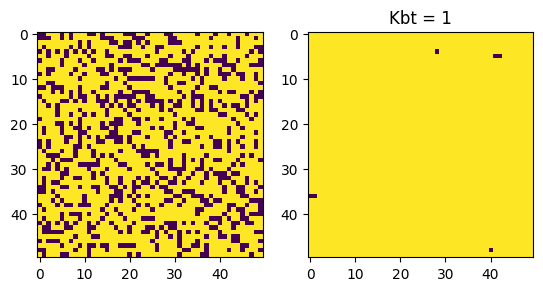

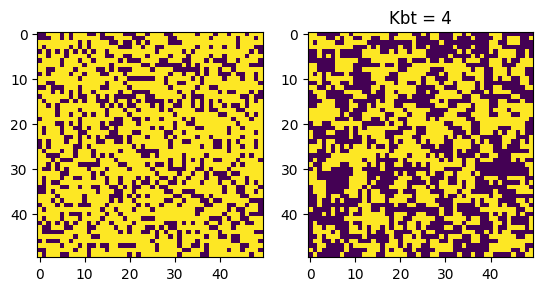

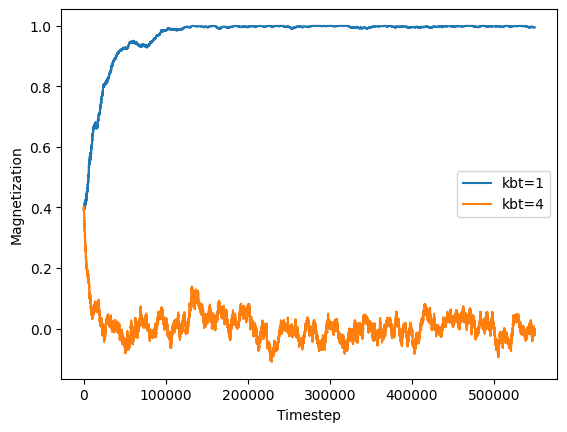

In [12]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 

seed = 239
rng = np.random.default_rng(seed)

def energy_pt(pick, model, mode = 1):             
    x, y = pick[0], pick[1]                    
    hori = model[(x-1)%n, y] + model[(x+1)%n, y]   # periodic boundary condition
    vert = model[x, (y-1)%n] + model[x, (y-1)%n]
    if mode == 1:                                  # mode 1: local energy
        return -1 * model[x,y] * (hori+vert)
    if mode == 2:                                  # mode 2: energy difference when flip
        return 2 * model[x,y] * (hori+vert)
    
def energy_grid(model):                                   # I tried previously, to update all the energy in the lattice at once
    left = np.roll(model, 1, axis = 1)                    # But the result behaves differently, although being much much more efficient ~30 seconds
    right = np.roll(model, -1, axis = 1)                  # For original model
    up = np.roll(model, 1, axis = 0)                      # the burn-in phase appears very quick ~50 time steps, and takes ~200 to stablize
    down = np.roll(model, -1, axis = 0)
    return -model*(left+right+up+down)

def magnetization_evolution(startconfig, timestep, kbt):
    config = startconfig.copy()
    config_storage = []
    magne_storage = np.zeros(timestep-1)

    for t in range(timestep-1):                       
        u = rng.uniform()
        coord = rng.choice(range(n), size=2)
        energy_differ = energy_pt(model = config, pick = coord, mode = 2) 

        if u < np.exp(-energy_differ / kbt):
            config[coord[0], coord[1]] = -1 * config[coord[0], coord[1]]          # probability ratio is the energy diference since exp function
            
        config_storage.append(config)
        magne_storage[t] = config.sum()
    
    return config_storage, magne_storage

n = 50
timestepsss = 550000                                     # Since only one position is updated at a time, now I have to do n^2 * 200 ~ 500000
start_config = rng.choice(np.array([-1, 1]), p = np.array([0.3, 0.7]), size=(n, n))   # start with 70% upspin

stor, mag = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=1)
stor111, mag111 = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=4)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(start_config)
ax2.imshow(stor[500000])
plt.title("Kbt = 1")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(start_config)
ax2.imshow(stor111[500000])
plt.title("Kbt = 4")
plt.show()


plt.plot(range(timestepsss-1), mag/2500, label="kbt=1")
plt.plot(range(timestepsss-1), mag111/2500, label="kbt=4")
plt.xlabel("Timestep")
plt.ylabel("Magnetization")
plt.legend()
plt.show()


c)

The varience of the magnetization is quivalent to heat capacity since:
$$
C_{v} = \frac{dE}{dT}
$$
Because of the large change in energy (equivalent to magnetization, from 1 to 0), the function presents a peak.

This large fluctuation during phase transition is **Schottky anomaly**. And is given by formula:
$$
C_{Schottky} = k_{B}(\frac{\epsilon}{k_{B}T})^2 \frac{exp(\frac{\epsilon}{k_{B}T})}{[exp(\frac{\epsilon}{k_{B}T}) + 1]^2}
$$

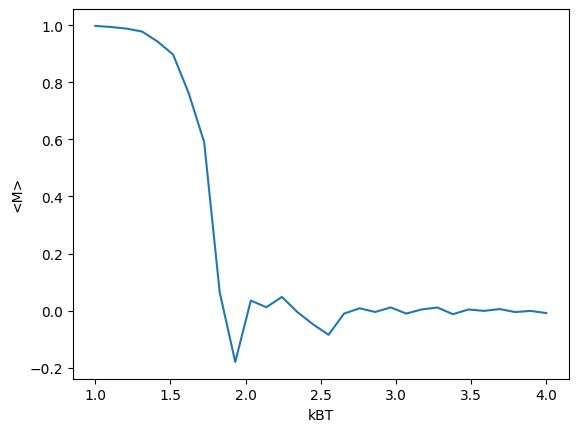

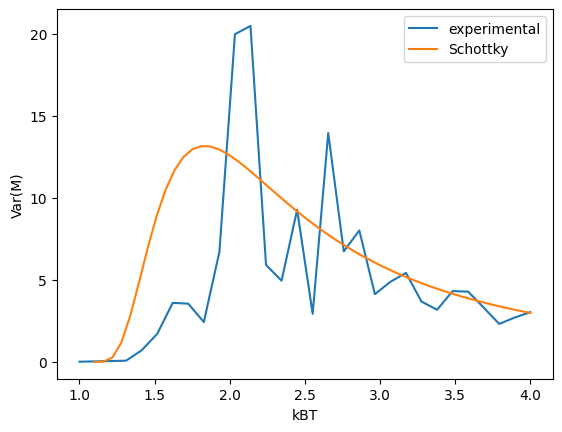

In [13]:
kbt_list = np.linspace(1, 4, 30)
mag_list = []
var_list = []
for kbt in kbt_list:
    storrr, maggg = magnetization_evolution(startconfig = start_config, timestep=timestepsss, kbt=kbt)
    mag_avg = np.mean(maggg[-200000:])
    ma_ver = np.var(maggg[-200000:])
    var_list.append(ma_ver)
    mag_list.append(mag_avg)

def schottky(kbt, energy = 2):
    kbt = kbt -1
    e = np.exp(energy / kbt)
    return (energy/kbt)**2 * e / (np.square(e+1))


plt.plot(kbt_list, np.array(mag_list)/n**2)

plt.xlabel("kBT")
plt.ylabel("<M>")
plt.show()

plt.plot(kbt_list, np.array(var_list)/n**2, label="experimental")
plt.plot(np.linspace(1.1, 4, 50), 30*schottky(np.linspace(1.1, 4, 50)), label="Schottky")
plt.xlabel("kBT")
plt.ylabel("Var(M)")
plt.legend()
plt.show()

### Appendix

